### Statistical Inference: Permutation test

1. Correlation
2. Moran's I

### Correlation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import *

url = 'https://raw.githubusercontent.com/mwaskom/seaborn-data/master/mpg.csv'

df = pd.read_csv(url)
df = df.dropna()

#### Lets draw a very small sample with only 10 points. 

In [2]:
small_sample_car = df.sample(10,random_state=222)
small_sample_car

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
165,20.0,8,262.0,110.0,3221,13.5,75,usa,chevrolet monza 2+2
380,36.0,4,120.0,88.0,2160,14.5,82,japan,nissan stanza xe
16,18.0,6,199.0,97.0,2774,15.5,70,usa,amc hornet
261,18.1,6,258.0,120.0,3410,15.1,78,usa,amc concord d/l
19,26.0,4,97.0,46.0,1835,20.5,70,europe,volkswagen 1131 deluxe sedan
99,18.0,6,232.0,100.0,2945,16.0,73,usa,amc hornet
206,26.5,4,140.0,72.0,2565,13.6,76,usa,ford pinto
86,14.0,8,304.0,150.0,3672,11.5,73,usa,amc matador
267,27.5,4,134.0,95.0,2560,14.2,78,japan,toyota corona
232,16.0,8,351.0,149.0,4335,14.5,77,usa,ford thunderbird


Text(0, 0.5, 'Acceleration')

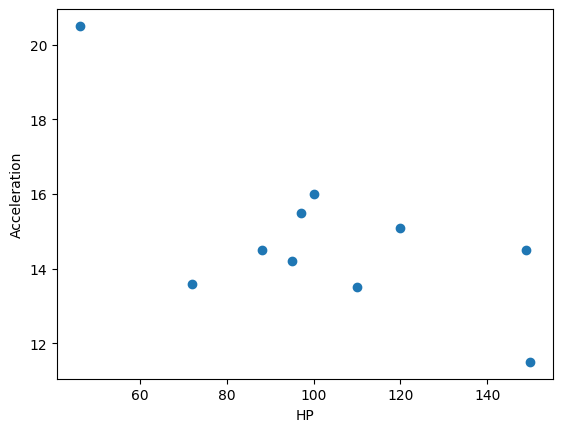

In [3]:
plt.scatter(small_sample_car.horsepower, small_sample_car.acceleration)
plt.xlabel("HP")
plt.ylabel("Acceleration")

#### Pearson correlation based on this small sample, note the analytical p-value here is ~0.03

In [4]:
pearson_rslt = pearsonr(small_sample_car.horsepower, small_sample_car.acceleration)

print("Pearson:",pearson_rslt)

Pearson: PearsonRResult(statistic=-0.6832264558183371, pvalue=0.02941732498278316)


In [5]:
np.random.permutation(small_sample_car.acceleration)

array([13.5, 14.5, 14.5, 20.5, 11.5, 16. , 13.6, 15.5, 15.1, 14.2])

#### Define a permutation test function for correlation:

In [6]:
def permutation_cor(sample_car):
    
    null_cor_list = []
    
    for i in range(10000):
        #permutate one variable, while hold the other constant.
        subsample_Y = np.random.permutation(sample_car.acceleration)
        
        #compute correlation
        sample_cor = pearsonr(sample_car.horsepower, subsample_Y)[0]

        null_cor_list.append(sample_cor)
    
    return null_cor_list
    

#### This gives us the correlation coefficient under the null hypothesis.

In [7]:
null_dist = permutation_cor(small_sample_car)

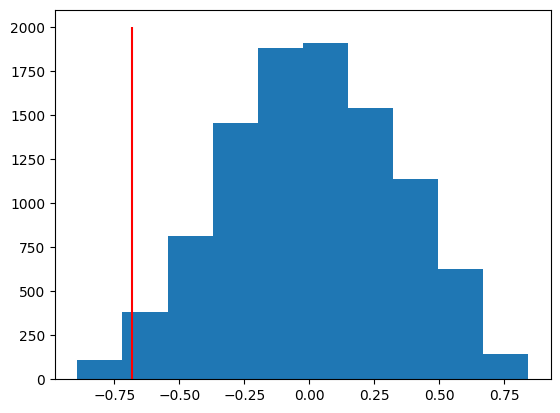

In [8]:
plt.hist(null_dist)

plt.vlines(pearson_rslt[0],ymin=0,ymax=2000,color="red")

#### Lets count how many times the correlation under unll would be greater (in magnitude) than the sample correlation.
#### This gives us a simulated p-value.

In [9]:
np.sum(np.abs(np.array(null_dist)) >= np.abs(pearson_rslt[0]))

276

In [10]:
import numpy as np
p_sim = np.sum(np.abs(np.array(null_dist)) >= np.abs(pearson_rslt[0]))/10000


In [11]:
print("The simulated p-value (2-tail): ", p_sim)

print("The actual p-value (2-tail) : ", pearson_rslt[1])

The simulated p-value (2-tail):  0.0276
The actual p-value (2-tail) :  0.02941732498278316


### Moran's I

Let's look at the spatial autocorrelation of ALAND in IL.

In [12]:
import geopandas as gpd

In [13]:
IL = gpd.read_file("/Users/ziqi/Desktop/GEOG 570 Online/data/IL_acs/IL_acs.shp")

DriverError: /Users/ziqi/Desktop/GEOG 570 Online/data/IL_acs/IL_acs.shp: No such file or directory

In [ ]:
IL.columns

In [ ]:
IL.plot(column="ALAND",legend=True)

#### Calculate the Moran's I values using the esda package.

In [ ]:
from libpysal.weights.contiguity import Queen

value = IL['ALAND'].values #Get the data we are interested.

w = Queen.from_dataframe(IL) #Generate W matrix using Queen contiguity

w.transform = 'r' #Row-standardization of the weight matrix

In [ ]:
from esda.moran import Moran
from splot.esda import plot_moran

il_moran = Moran(value, w, permutations=100, two_tailed=True)


print("Moran's I:", il_moran.I)

print("analytical p-value:",il_moran.p_norm)

print("Simulated p-value:",il_moran.p_sim)

In [ ]:
plot_moran(il_moran, zstandard=True, figsize=(10,4))
plt.show()

In [ ]:
#Define a permutation test function for Moran's I:
def permutation_moran(geodataframe):
    
    w = Queen.from_dataframe(IL) 
    
    null_moran_list = []
    
    for i in range(1000):
        
        value = np.random.permutation(geodataframe['ALAND'].values) #Get the data we are interested.
        
        #compute moran's I
        moran = Moran(value, w)
        
        null_moran_list.append(moran.I)
    
    return null_moran_list
    

In [ ]:
from esda.moran import Moran
from splot.esda import plot_moran

il_moran = Moran(value, w, permutations=100, two_tailed=True)


print("Moran's I:", il_moran.I)

print("analytical p-value:",il_moran.p_norm)

print("Simulated p-value:",il_moran.p_sim)

#### We randomly assign a value to each county, and calculate Moran's I for each map.

In [ ]:
import numpy as np
IL.plot(column=np.random.permutation(IL['pct_bach'].values),legend=True)

Moran's I under the null hypothesis

In [ ]:
null_moran = permutation_moran(IL)

In [ ]:
plt.hist(null_moran)
plt.vlines(il_moran.I,ymin=0,ymax=300,color="red")

In [ ]:
p_sim = np.sum(np.abs(np.array(null_moran)) >= np.abs(il_moran.I))/1000


In [ ]:
print("Analytical p-value:",il_moran.p_norm)
print("Simulated p-value from esda's permutation:",il_moran.p_sim)

print("Simulated p-value from permutation test:",p_sim)